In [0]:
try:
  %tensorflow_version 2.x
except:
  pass
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, BatchNormalization, Dense
from tensorflow.keras.models import Model
# Load pretrained model from keras.applications. Alternative: TensorflowHub
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train, y_test = y_train.flatten(), y_test.flatten()
K = len(set(y_train))
print('Number of classes: ' + str(K))

Number of classes: 10


In [0]:
ptm = PretrainedModel(input_shape=x_train.shape[1:], weights='imagenet', include_top=False)
ptm = Model(ptm.input, Flatten()(ptm.output))
ptm.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [0]:
# Transform images to feature vectors (SLOW!)
# TODO: faster with generators?
X_train = ptm.predict(preprocess_input(x_train))
X_test = ptm.predict(preprocess_input(x_test))

In [0]:
# Number of features produced by the pretrained CNN model
D = ptm.layers[-1].output_shape[1]

# Train a model to do classification from the feature vectors
i = Input(shape=(D,))
x = BatchNormalization()(i)
# x = Dropout(0.2)(x)
x = Dense(units=D)(x)
# x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

m = Model(i, x)
m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
r = m.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=25)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 181us/sample - loss: 1.2470 - accuracy: 0.5841 - val_loss: 1.0781 - val_accuracy: 0.6311
Epoch 2/25
50000/50000 [==============================] - 8s 158us/sample - loss: 1.1072 - accuracy: 0.6143 - val_loss: 1.0710 - val_accuracy: 0.6362
Epoch 3/25
50000/50000 [==============================] - 8s 157us/sample - loss: 1.0918 - accuracy: 0.6209 - val_loss: 1.0777 - val_accuracy: 0.6276
Epoch 4/25
50000/50000 [==============================] - 8s 159us/sample - loss: 1.0844 - accuracy: 0.6230 - val_loss: 1.0563 - val_accuracy: 0.6428
Epoch 5/25
50000/50000 [==============================] - 8s 158us/sample - loss: 1.0741 - accuracy: 0.6235 - val_loss: 1.0529 - val_accuracy: 0.6433
Epoch 6/25
50000/50000 [==============================] - 8s 160us/sample - loss: 1.0622 - accuracy: 0.6293 - val_loss: 1.0463 - val_accuracy: 0.6412
Epoch 7/25
50000/50000 [==========================

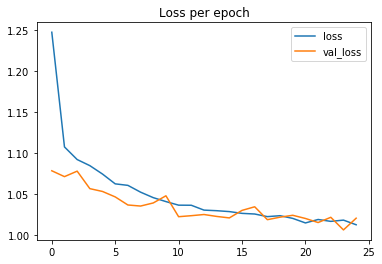

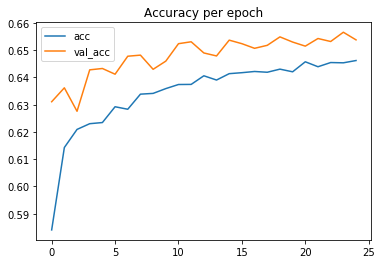

In [0]:
plt.title('Loss per epoch')
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.title('Accuracy per epoch')
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [0]:
# Combined model: preprocess_input + ptm + m
def cm_predict(x):
  return m.predict(ptm.predict(preprocess_input(x)))

cm_predict(x_test[0:5]).argmax(axis=1)

array([3, 8, 8, 8, 6])

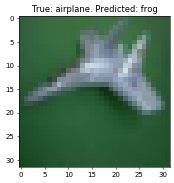

Continue? (Y/n): Y


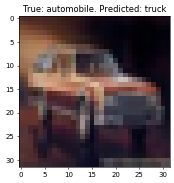

Continue? (Y/n): Y


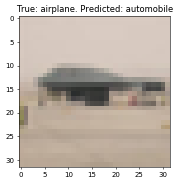

Continue? (Y/n): n


In [0]:
# Show some misclassified examples
p_test = m.predict(X_test).argmax(axis=1)  # faster to start from the feature vectors
misclassified_idx = np.where(p_test != y_test)[0]
labels = [
  'airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck',
]
while True:
  i = np.random.choice(misclassified_idx)
  plt.figure(dpi=50)
  plt.imshow(x_test[i], cmap='gray')
  plt.title("True: %s. Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));
  plt.show()
  if input(prompt='Continue? (Y/n): ') == 'n': break